Generated 1000 time data points and 1000 position data points for t = 0 to 50.0s.

Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,153 (4.50 KB)

 Trainable params: 1,153 (4.50 KB)

 Non-trainable params: 0 (0.00 B)


Defined EarlyStopping (patience=50) and ReduceLROnPlateau (patience=20) callbacks.

Starting model training for up to 1000 epochs...
Epoch 1/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.4698 - mae: 1.1343 - val_loss: 1.1182 - val_mae: 1.0548 - learning_rate: 0.0010
Epoch 2/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1536 - mae: 0.3285 - val_loss: 0.0648 - val_mae: 0.2533 - learning_rate: 0.0010
Epoch 3/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0683 - mae: 0.1905 - val_loss: 1.6706e-04 - val_mae: 0.0116 - learning_rate: 0.0010
Epoch 4/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0476 - mae: 0.1437 - val_loss: 0.0019 - val_mae: 0.0425 - learning_rate: 0.0010
Epoch 5/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0575 - mae: 0.1571 - val_loss: 1.9756e-04 - val_mae: 0.0118 - learning_rate: 0.0010
Epoch 6/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0581 - mae: 0.1541 - val_loss: 8.5290e-05 - val_mae: 0.0078 - learning_rate: 0.0010
E

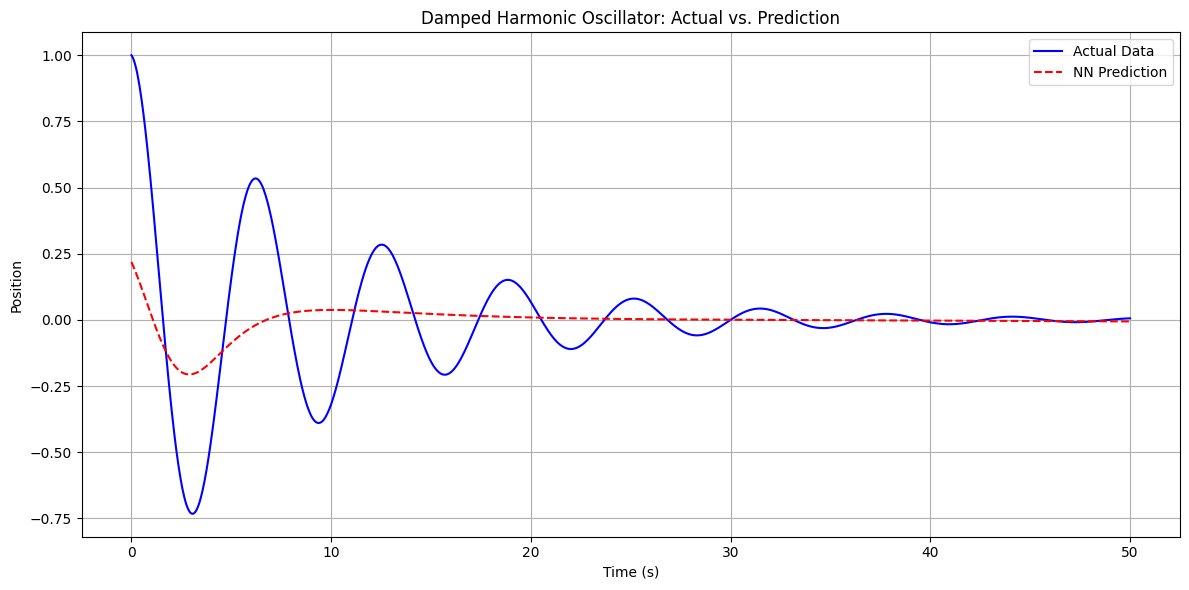

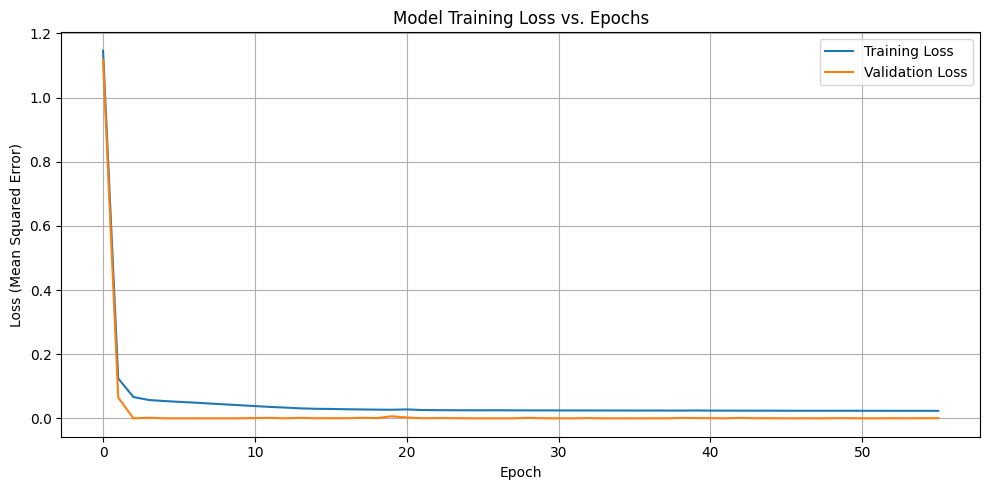

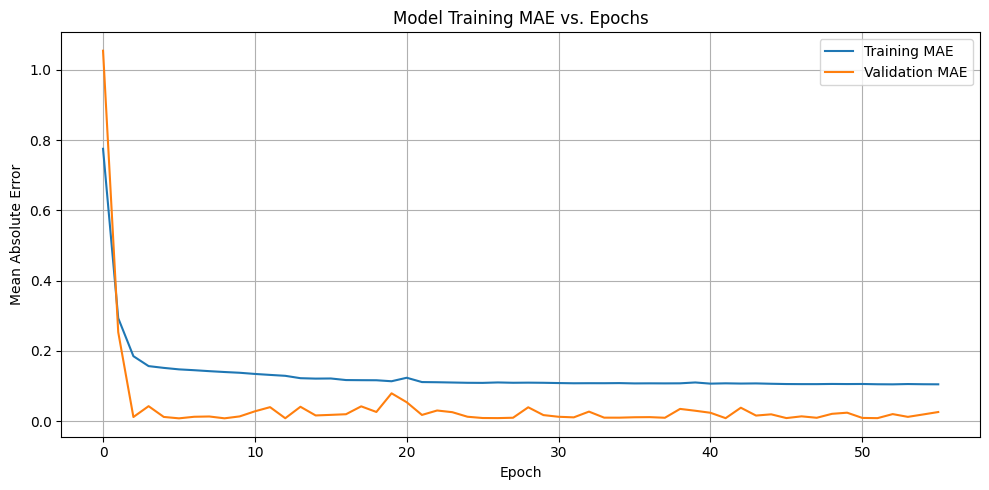

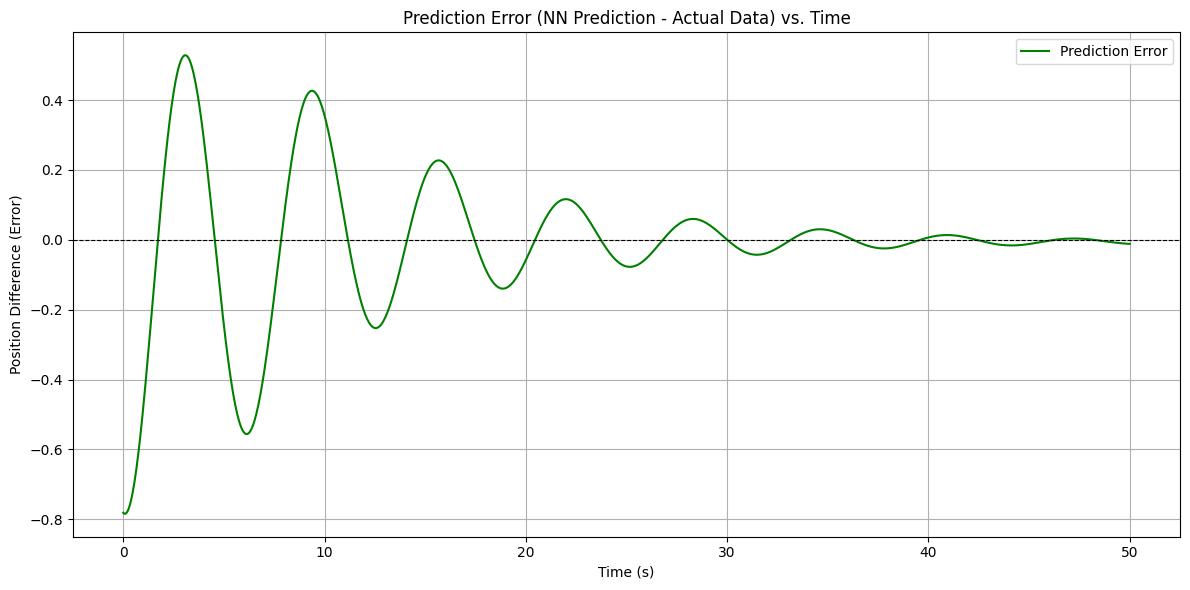


Script execution finished.


In [3]:
# --- Third-party Library Imports ---
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# --- Custom Activation Function ---
def x_sech_x(x, rho=1.0):
    """
    Implementiert eine Sigmoid-weighted Linear Unit basierend auf der Formel:
    f(x) = x / (1 + exp(-2x / rho))

    Diese Funktion skaliert die Eingabe x mit einer Sigmoid-ähnlichen Kurve.
    Der Parameter rho steuert die Steilheit der Kurve um den Ursprung.

    Argumente:
        x (tf.Tensor): Der Eingabe-Tensor.
        rho (float): Ein anpassbarer Parameter zur Steuerung der Form.
                     Standardwert ist 1.0.

    Rückgabe:
        tf.Tensor: Der Tensor nach Anwendung der Aktivierungsfunktion.
    """
    # Die Formel kann direkt mit TensorFlow-Operationen umgesetzt werden.
    # tf.sigmoid(y) ist mathematisch äquivalent zu 1 / (1 + exp(-y)).
    # Hier ist y = 2x / rho.
    return x * tf.sigmoid(2 * x / rho)


# --- Custom Weight Initializers ---
class CustomInitializerFirstLayer(tf.keras.initializers.Initializer):
    """
    Custom weight initializer for the first hidden layer.
    Initializes weights uniformly within the range [-sqrt(6/33), sqrt(6/33)].
    This range is derived from Xavier/Glorot initialization principles,
    where the limit is sqrt(6 / (fan_in + fan_out)).
    For the first layer: fan_in=1 (input dimension from time data), fan_out=32 (units in this layer).
    So, limit = sqrt(6 / (1 + 32)) = sqrt(6/33).
    """
    def __init__(self):
        super().__init__()
        # Calculate limits for uniform distribution.
        limit = np.sqrt(6 / (1 + 32))
        self.minval = -limit
        self.maxval = limit

    def __call__(self, shape, dtype=None):
        # Returns a tensor of the given shape filled with values from the uniform distribution.
        return tf.random.uniform(
            shape, minval=self.minval, maxval=self.maxval, dtype=dtype
        )

    def get_config(self):
        # Returns a serializable dictionary of arguments used to initialize this initializer.
        return {"minval": self.minval, "maxval": self.maxval}

class CustomInitializerSecondLayer(tf.keras.initializers.Initializer):
    """
    Custom weight initializer for the second hidden layer.
    Initializes weights uniformly within the range [-sqrt(3/32), sqrt(3/32)].
    This range is also based on Xavier/Glorot initialization:
    For the second layer: fan_in=32 (units from previous layer), fan_out=32 (units in this layer).
    So, limit = sqrt(6 / (32 + 32)) = sqrt(6/64) = sqrt(3/32).
    """
    def __init__(self):
        super().__init__()
        # Calculate limits for uniform distribution.
        limit = np.sqrt(6 / (32 + 32)) # Equivalent to np.sqrt(3/32)
        self.minval = -limit
        self.maxval = limit

    def __call__(self, shape, dtype=None):
        return tf.random.uniform(
            shape, minval=self.minval, maxval=self.maxval, dtype=dtype
        )

    def get_config(self):
        return {"minval": self.minval, "maxval": self.maxval}

# --- Model Definition ---
def build_model(input_shape=(1,)):
    """
    Builds and compiles the neural network model for the oscillator.

    Args:
        input_shape (tuple): The shape of the input data (e.g., (1,) for a single time feature).

    Returns:
        tf.keras.Model: The compiled Keras model.
    """
    model = Sequential([
        # First hidden layer:
        # - 32 units (neurons): Determines the layer's capacity.
        # - Custom activation function `x_sech_x`: Introduces non-linearity.
        # - Custom weight initializer `CustomInitializerFirstLayer`: Sets initial weights.
        # - input_shape: Defines the shape of the input (a single feature, time).
        Dense(32, activation=x_sech_x, kernel_initializer=CustomInitializerFirstLayer(), input_shape=input_shape, name="hidden_layer_1"),

        # Second hidden layer:
        # - 32 units: Further processes features from the previous layer.
        # - 'tanh' activation function (hyperbolic tangent): Another common non-linear activation.
        # - Custom weight initializer `CustomInitializerSecondLayer`: Sets initial weights.
        Dense(32, activation=x_sech_x, kernel_initializer=CustomInitializerFirstLayer(), name="hidden_layer_2"),

        # Output layer:
        # - 1 unit: Predicts the oscillator's position (a single continuous value).
        # - Linear activation (default for Dense layer): Suitable for regression outputs.
        Dense(1, name="output_layer")
    ])

    # Compile the model:
    # - Optimizer: Adam (Adaptive Moment Estimation) is an efficient and widely used optimizer.
    #   It adapts learning rates for each parameter.
    # - Loss function: 'mean_squared_error' (MSE) is suitable for regression tasks.
    #   It measures the average squared difference between actual and predicted values, penalizing larger errors more.
    # - Metrics: 'mae' (Mean Absolute Error) provides another measure of prediction accuracy,
    #   representing the average absolute difference between predictions and actuals. It's less sensitive to outliers than MSE.
    model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])
    return model

# --- Data Generation Function ---
def generate_damped_oscillator_data(
    amplitude: float = 1.0,
    damping_coefficient: float = 0.1,  # Denoted as gamma (γ) in physics
    angular_frequency_natural: float = 1.0,  # Denoted as omega_0 (ω₀)
    phase: float = 0.0, # Denoted as phi (φ)
    t_end: float = 50.0,
    num_points: int = 1000,
):
    """
    Generates data for an underdamped harmonic oscillator.

    The formula used for an underdamped oscillator is:
    x(t) = A * exp(-γ*t) * cos(ω_d*t + φ)
    where:
        A = amplitude (initial amplitude)
        γ = damping_coefficient (controls the rate of decay)
        ω₀ = angular_frequency_natural (frequency if no damping)
        φ = phase (initial phase shift)
        ω_d = sqrt(ω₀² - γ²) is the damped angular frequency (actual oscillation frequency under damping).

    Args:
        amplitude (float): Initial amplitude of the oscillation.
        damping_coefficient (float): Damping coefficient (γ). Must be less than
                                     angular_frequency_natural for underdamped oscillation.
        angular_frequency_natural (float): Natural angular frequency (ω₀) if there were no damping.
        phase (float): Initial phase (φ) of the oscillation, in radians.
        t_end (float): The end time for the simulation (e.g., 50 seconds).
        num_points (int): The number of data points to generate over the time interval [0, t_end].

    Returns:
        A tuple containing two numpy arrays:
        t (numpy.ndarray): Time points from 0 to t_end.
        x (numpy.ndarray): Position of the oscillator at each corresponding time point.

    Raises:
        ValueError: If damping_coefficient is not less than angular_frequency_natural,
                    as this would not result in an underdamped oscillation.
    """
    t = np.linspace(0, t_end, num_points) # Time vector

    # Condition for underdamped oscillation: natural frequency must be greater than damping coefficient.
    # If γ >= ω₀, the system is critically damped or overdamped, and won't oscillate sinusoidally.
    if angular_frequency_natural <= damping_coefficient:
        raise ValueError(
            "For underdamped oscillation, natural frequency (angular_frequency_natural) "
            "must be greater than damping_coefficient."
        )

    # Calculate damped angular frequency (ω_d)
    omega_damped = np.sqrt(angular_frequency_natural**2 - damping_coefficient**2)

    # Calculate position x(t) using the damped harmonic oscillator equation
    x = amplitude * np.exp(-damping_coefficient * t) * np.cos(omega_damped * t + phase)

    return t, x

# --- Plotting Function ---
def plot_results(time, actual_position, predicted_position, history):
    """
    Plots the results of the model training and prediction.

    Args:
        time (numpy.ndarray): Array of time points.
        actual_position (numpy.ndarray): Array of actual oscillator positions.
        predicted_position (numpy.ndarray): Array of predicted oscillator positions from the model.
        history (tf.keras.callbacks.History): History object from model.fit(), containing training metrics.
    """

    # Plot 1: Comparison of Actual Data and Neural Network Prediction
    # This plot shows how well the model's predictions (red dashed line) align with
    # the true oscillator behavior (blue solid line) over time.
    # Ideal scenario: The two lines overlap closely.
    plt.figure(figsize=(12, 6))
    plt.plot(time, actual_position, label='Actual Data', color='blue', linestyle='-')
    plt.plot(time, predicted_position, label='NN Prediction', color='red', linestyle='--')
    plt.title('Damped Harmonic Oscillator: Actual vs. Prediction')
    plt.xlabel('Time (s)')
    plt.ylabel('Position')
    plt.legend()
    plt.grid(True)
    plt.tight_layout() # Adjusts plot parameters for a tight layout.
    plt.show()

    # Plot 2: Model Training Loss (Mean Squared Error) vs. Epochs
    # This plot displays the model's loss (error, specifically MSE) on the training set
    # and optionally on the validation set for each epoch.
    # Helps to assess if the model is learning effectively and to spot issues like overfitting
    # (where validation loss starts increasing while training loss continues to decrease).
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history: # Check if validation loss is available
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Training Loss vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Mean Squared Error)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 3: Model Training Mean Absolute Error (MAE) vs. Epochs
    # This plot shows the MAE on the training and validation sets. MAE is another metric
    # for regression, representing the average absolute difference between predictions and actual values.
    # It gives a more direct sense of the average error magnitude.
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['mae'], label='Training MAE')
    if 'val_mae' in history.history: # Check if validation MAE is available
        plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model Training MAE vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 4: Difference between Prediction and Actual Data vs. Time (Prediction Error/Residuals)
    # This plot shows the residuals (prediction - actual) over time.
    # It can help identify if the model has systematic errors (e.g., consistently
    # over or under-predicting in certain regions, or if errors correlate with time).
    # Ideally, errors should be small and randomly distributed around zero.
    difference = predicted_position.flatten() - actual_position.flatten() # Ensure both are 1D arrays for subtraction
    plt.figure(figsize=(12, 6))
    plt.plot(time, difference, color='green', label='Prediction Error')
    plt.title('Prediction Error (NN Prediction - Actual Data) vs. Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Position Difference (Error)')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8) # Add a zero line for reference
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Main Execution Block ---
if __name__ == "__main__":
    # --- 1. Data Generation ---
    # Generate time and position data for the damped harmonic oscillator.
    # These parameters can be adjusted to simulate different oscillator behaviors.
    TIME_END = 50.0
    NUM_POINTS = 1000
    time_data, position_data = generate_damped_oscillator_data(
        amplitude=1.0,
        damping_coefficient=0.1, # γ
        angular_frequency_natural=1.0, # ω₀
        phase=0.0, # φ
        t_end=TIME_END,
        num_points=NUM_POINTS
    )
    print(f"Generated {len(time_data)} time data points and {len(position_data)} position data points "
          f"for t = 0 to {TIME_END}s.")

    # --- 2. Model Building ---
    # Build the neural network model with the defined architecture and custom components.
    # input_shape=(1,) because our input is a single feature (time).
    model = build_model(input_shape=(1,))
    # Display a summary of the model's architecture (layers, output shapes, number of parameters).
    print("\nModel Summary:")
    model.summary()

    # --- 3. Callbacks Definition ---
    # Callbacks are functions applied at certain stages of the training process (e.g., end of epoch).

    # EarlyStopping: Stops training when a monitored metric has stopped improving.
    # - monitor='val_loss': Metric to monitor (validation loss).
    # - patience=50: Number of epochs with no improvement in 'val_loss' after which training will be stopped.
    # - restore_best_weights=True: If training stops due to patience, model weights are reverted
    #   to those from the epoch with the best 'val_loss'.
    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

    # ReduceLROnPlateau: Reduces the learning rate when 'val_loss' has stopped improving.
    # This can help the model make finer adjustments and converge more effectively if it plateaus.
    # - monitor='val_loss': Metric to monitor.
    # - factor=0.2: Factor by which the learning rate will be reduced (new_lr = lr * factor).
    # - patience=20: Number of epochs with no improvement after which learning rate will be reduced.
    # - min_lr=0.0001: Lower bound on the learning rate; it won't be reduced below this value.
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, min_lr=0.0001)

    callbacks_list = [early_stopping, reduce_lr]
    print("\nDefined EarlyStopping (patience=50) and ReduceLROnPlateau (patience=20) callbacks.")

    # Reshape time_data for the model input: Keras expects input data to have a shape of (samples, features).
    # Our time_data is currently (NUM_POINTS,), needs to be (NUM_POINTS, 1).
    time_data_reshaped = np.reshape(time_data, (-1, 1))

    # --- 4. Model Training ---
    EPOCHS = 1000 # Maximum number of epochs for training.
    VALIDATION_SPLIT = 0.2 # Fraction of training data to use for validation.
    print(f"\nStarting model training for up to {EPOCHS} epochs...")

    # Train the model using the generated data. The 'history' object will store training metrics.
    history = model.fit(
        time_data_reshaped, # Input data (time, reshaped)
        position_data,      # Target data (oscillator position)
        epochs=EPOCHS,      # Maximum number of training cycles through the entire dataset.
                            # EarlyStopping might stop training sooner if val_loss plateaus.
        validation_split=VALIDATION_SPLIT, # Fraction of the training data set aside for validation (20%).
                                           # This data is not used for training weights but for evaluating
                                           # loss and metrics at the end of each epoch. It helps monitor
                                           # for overfitting to the training data.
        callbacks=callbacks_list, # List of callbacks to apply during training.
        verbose=1             # Verbosity mode: 1 = progress bar during training.
    )
    print("Model training completed.")
    final_epoch_count = len(history.history['loss'])
    print(f"Training finished after {final_epoch_count} epochs.")


    # --- 5. Prediction Generation ---
    # Use the trained model to make predictions on the original time data (reshaped).
    print("\nGenerating predictions using the trained model...")
    predicted_position_data = model.predict(time_data_reshaped)
    print("Predictions generated.")

    # --- 6. Plotting Results ---
    # Visualize the training process and the model's performance by comparing
    # actual data with predictions and showing training history.
    print("\nPlotting results...")
    plot_results(time_data, position_data, predicted_position_data, history)
    print("\nScript execution finished.")

Epoch 1000, Loss: 0.109147
Epoch 2000, Loss: 0.086468
Epoch 3000, Loss: 0.051059
Epoch 4000, Loss: 0.030479
Epoch 5000, Loss: 0.026295
Epoch 6000, Loss: 0.023128
Epoch 7000, Loss: 0.019180
Epoch 8000, Loss: 0.007655
Epoch 9000, Loss: 0.000555
Epoch 10000, Loss: 0.000086
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Mean Squared Error: 0.000002
Number of Parameters: 901


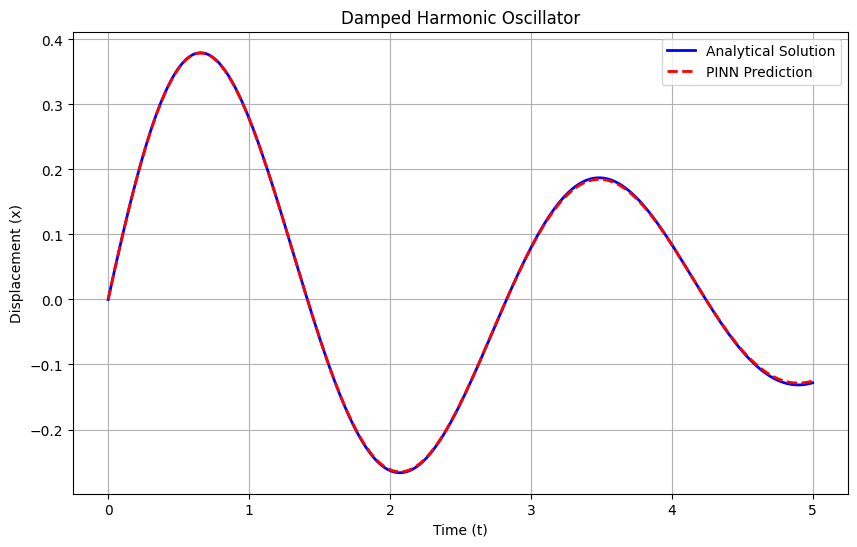

In [10]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Define the physical parameters
m = 1.0
mu = 0.5
k = 5.0

# Define the initial conditions
t0 = 0.0
x0 = 0.0
v0 = 1.0

# Build the Neural Network Model (this part is correct)
def build_model(num_hidden_layers=3, num_neurons_per_layer=20):
    """
    Creates a simple feed-forward neural network.
    """
    model = keras.Sequential()
    model.add(layers.InputLayer(shape=(1,)))
    for _ in range(num_hidden_layers):
        model.add(layers.Dense(num_neurons_per_layer, activation='tanh'))
    model.add(layers.Dense(1))
    return model

# Create the model and the optimizer
pinn_model = build_model()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

# Define the time points for training
t_train = tf.constant(np.linspace(0, 5, 200), dtype=tf.float32)[:, tf.newaxis]
t_initial = tf.constant([[t0]], dtype=tf.float32)

@tf.function
def train_step(model, optimizer, t_domain, t_initial_cond):
    """
    Performs a single training step using the correct method for higher-order derivatives.
    """
    with tf.GradientTape() as tape:
        # The main tape for updating model weights. It watches everything by default.

        # --- CORRECTED DERIVATIVE CALCULATION using Nested Tapes ---
        with tf.GradientTape() as outer_deriv_tape:
            outer_deriv_tape.watch(t_domain)
            with tf.GradientTape() as inner_deriv_tape:
                inner_deriv_tape.watch(t_domain)
                x = model(t_domain)
            # First derivative
            dx_dt = inner_deriv_tape.gradient(x, t_domain)
        # Second derivative
        d2x_dt2 = outer_deriv_tape.gradient(dx_dt, t_domain)
        # --- End of Correction ---

        # Physics Loss
        physics_residual = d2x_dt2 + (mu / m) * dx_dt + (k / m) * x
        physics_loss = tf.reduce_mean(tf.square(physics_residual))

        # Data Loss (Initial Conditions)
        with tf.GradientTape() as initial_tape:
            initial_tape.watch(t_initial_cond)
            x_at_t0 = model(t_initial_cond)

        v_at_t0 = initial_tape.gradient(x_at_t0, t_initial_cond)

        data_loss_pos = tf.square(x_at_t0 - x0)
        data_loss_vel = tf.square(v_at_t0 - v0)
        data_loss = tf.reduce_sum(data_loss_pos + data_loss_vel)

        # Total Loss
        total_loss = physics_loss + data_loss

    # Compute and apply gradients for the model's weights
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return total_loss

# --- The Training Loop ---
epochs = 10000
for epoch in range(epochs):
    loss = train_step(pinn_model, optimizer, t_train, t_initial)
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.numpy():.6f}")


# --- Evaluation ---
# Analytical solution for comparison
def analytical_solution(t, mu, k, x0, v0):
    omega0 = np.sqrt(k)
    zeta = mu / (2 * omega0)
    if zeta < 1: # Underdamped
        omega_d = omega0 * np.sqrt(1 - zeta**2)
        A = x0
        B = (v0 + zeta * omega0 * x0) / omega_d
        return np.exp(-zeta * omega0 * t) * (A * np.cos(omega_d * t) + B * np.sin(omega_d * t))
    elif zeta == 1: # Critically damped
        A = x0
        B = v0 + omega0 * x0
        return (A + B * t) * np.exp(-omega0 * t)
    else: # Overdamped
        r1 = -zeta * omega0 + omega0 * np.sqrt(zeta**2 - 1)
        r2 = -zeta * omega0 - omega0 * np.sqrt(zeta**2 - 1)
        c1 = (v0 - r2 * x0) / (r1 - r2)
        c2 = (x0 * r1 - v0) / (r1 - r2)
        return c1 * np.exp(r1 * t) + c2 * np.exp(r2 * t)

t_test = np.linspace(0, 5, 200)
x_pred = pinn_model.predict(t_test).flatten()
x_analytical = analytical_solution(t_test, mu, k, x0, v0)

# Calculate Mean Squared Error
mse = np.mean((x_pred - x_analytical)**2)
print(f"\nMean Squared Error: {mse:.6f}")
print(f"Number of Parameters: {pinn_model.count_params()}")


# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_test, x_analytical, 'b-', linewidth=2, label='Analytical Solution')
plt.plot(t_test, x_pred, 'r--', linewidth=2, label='PINN Prediction')
plt.title('Damped Harmonic Oscillator')
plt.xlabel('Time (t)')
plt.ylabel('Displacement (x)')
plt.legend()
plt.grid(True)
plt.show()

Model: "Damped_Oscillator_Solver"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_x (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,153 (4.50 KB)

 Trainable params: 1,153 (4.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1000, Loss: 0.000316
Epoch 2000, Loss: 0.000030
Epoch 3000, Loss: 0.000015
Epoch 4000, Loss: 0.000006
Epoch 5000, Loss: 0.000004
Epoch 6000, Loss: 0.000002
Epoch 7000, Loss: 0.000015
Epoch 8000, Loss: 0.000001
Epoch 9000, Loss: 0.000001
Epoch 10000, Loss: 0.000001
Epoch 11000, Loss: 0.000001
Epoch 12000, Loss: 0.000001
Epoch 13000, Loss: 0.000001
Epoch 14000, Loss: 0.000000


Epoch 15000, Loss: 0.000000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Mean Squared Error vs Analytical Solution: 0.000000


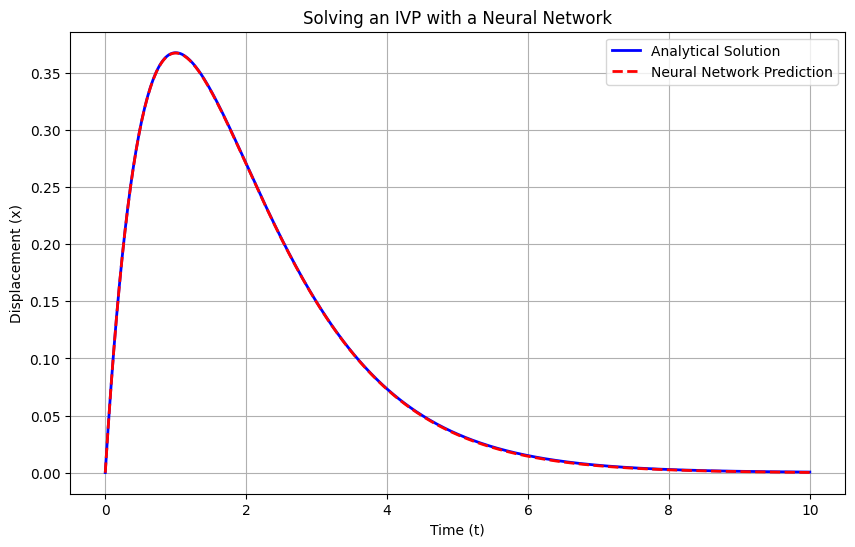

In [11]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Define the Physics and Network Parameters ---

# Damped Harmonic Oscillator Parameters
# m*x'' + mu*x' + k*x = 0 (we'll assume m=1)
mu = 2.0  # Damping coefficient (critically damped case for mu=2, k=1)
k = 1.0   # Spring constant

# Initial Conditions
t0 = 0.0
x0 = 0.0  # Initial position
v0 = 1.0  # Initial velocity

# Neural Network Architecture
num_hidden_layers = 2
num_neurons_per_layer = 32

# --- 2. Build the Neural Network ---

# We build a simple feed-forward network
# Input: t (time)
# Output: x (position)
model = keras.Sequential(name="Damped_Oscillator_Solver")
model.add(layers.InputLayer(shape=(1,)))
for i in range(num_hidden_layers):
    model.add(layers.Dense(num_neurons_per_layer, activation='tanh', name=f'hidden_{i+1}'))
model.add(layers.Dense(1, name='output_x'))

model.summary()


# --- 3. Create the Custom Loss Function ---

def physics_informed_loss(y_true, y_pred):
    """
    This is the core of the solver.
    It does not use y_true or y_pred. Instead, it uses the model's
    input `t` to calculate the loss based on the differential equation.

    NOTE: In TF 2.x, the model's inputs are not directly passed to the loss
    function. We will wrap this logic in the training step.
    This function's signature is kept for compatibility with model.compile().
    """
    # This function is a placeholder for the logic we'll use in the train_step
    return 0.0

# Because the loss calculation depends on the input `t`, we must
# define a custom training step.

# Convert constants to TensorFlow constants
t_initial_cond = tf.constant([[t0]], dtype=tf.float32)

# Use @tf.function to compile the training step into a high-performance graph
@tf.function
def train_step(model, optimizer, t_domain):
    """
    Performs a single custom training step.
    """
    with tf.GradientTape() as tape:
        # The main tape watches the model's trainable variables to apply gradients.

        # --- Physics Loss Calculation ---
        # We need nested tapes to compute second derivatives.
        with tf.GradientTape() as outer_deriv_tape:
            outer_deriv_tape.watch(t_domain)
            with tf.GradientTape() as inner_deriv_tape:
                inner_deriv_tape.watch(t_domain)
                # Model prediction for x at all time points
                x = model(t_domain)
            # First derivative (velocity)
            dx_dt = inner_deriv_tape.gradient(x, t_domain)
        # Second derivative (acceleration)
        d2x_dt2 = outer_deriv_tape.gradient(dx_dt, t_domain)

        # The residual of the differential equation
        # We want this to be zero: d2x_dt2 + mu*dx_dt + k*x = 0
        physics_residual = d2x_dt2 + mu * dx_dt + k * x

        # The absolute value square of the differential equation
        loss_physics = tf.reduce_mean(tf.square(physics_residual))

        # --- Initial Conditions Loss Calculation ---
        with tf.GradientTape() as initial_tape:
            initial_tape.watch(t_initial_cond)
            # Model prediction for position at t=0
            x_at_t0 = model(t_initial_cond)
        # Model prediction for velocity at t=0
        v_at_t0 = initial_tape.gradient(x_at_t0, t_initial_cond)

        # The square of the differences of initial conditions
        loss_ic_pos = tf.square(x_at_t0 - x0)
        loss_ic_vel = tf.square(v_at_t0 - v0)
        loss_ic = tf.reduce_sum(loss_ic_pos + loss_ic_vel)

        # --- Total Loss ---
        total_loss = loss_physics + loss_ic

    # Calculate gradients of the total loss with respect to the model's weights
    grads = tape.gradient(total_loss, model.trainable_variables)
    # Apply the gradients to update the weights
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return total_loss

# --- 4. Train the Network ---

# Define the optimizer
optimizer = keras.optimizers.Adam(learning_rate=0.001)

# Define the time domain for training (these are just collocation points)
t_domain_train = tf.constant(np.linspace(0, 10, 500), dtype=tf.float32)[:, tf.newaxis]

# The training loop
epochs = 15000
for epoch in range(epochs):
    loss = train_step(model, optimizer, t_domain_train)
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.numpy():.6f}")


# --- 5. Evaluate the Results ---

# Get the analytical solution for comparison
# This is for a critically damped oscillator (mu=2, k=1)
def analytical_solution(t, v0, x0):
    return (x0 + (v0 + k * x0) * t) * np.exp(-k * t)

# Generate a test set of time points
t_test = np.linspace(0, 10, 500)
# Get the model's prediction
x_pred = model.predict(t_test).flatten()
# Get the true analytical solution
x_analytical = analytical_solution(t_test, v0, x0)

# Calculate Mean Squared Error
mse = np.mean((x_pred - x_analytical)**2)
print(f"\nMean Squared Error vs Analytical Solution: {mse:.6f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_test, x_analytical, 'b-', linewidth=2, label='Analytical Solution')
plt.plot(t_test, x_pred, 'r--', linewidth=2, label='Neural Network Prediction')
plt.title('Solving an IVP with a Neural Network')
plt.xlabel('Time (t)')
plt.ylabel('Displacement (x)')
plt.legend()
plt.grid(True)
plt.show()

Model: "Underdamped_Oscillator_Solver"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_x (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,153 (4.50 KB)

 Trainable params: 1,153 (4.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1000, Loss: 0.079005
Epoch 2000, Loss: 0.035382
Epoch 3000, Loss: 0.028563
Epoch 4000, Loss: 0.020183
Epoch 5000, Loss: 0.016127
Epoch 6000, Loss: 0.018520
Epoch 7000, Loss: 0.013760
Epoch 8000, Loss: 0.013021
Epoch 9000, Loss: 0.012349
Epoch 10000, Loss: 0.011701
Epoch 11000, Loss: 0.011069
Epoch 12000, Loss: 0.010769
Epoch 13000, Loss: 0.009987
Epoch 14000, Loss: 0.009250
Epoch 15000, Loss: 0.008721
Epoch 16000, Loss: 0.008224
Epoch 17000, Loss: 0.007649
Epoch 18000, Loss: 0.006812
Epoch 19000, Loss: 0.005740
Epoch 20000, Loss: 0.005243
Epoch 21000, Loss: 0.004998
Epoch 22000, Loss: 0.004644
Epoch 23000, Loss: 0.004385
Epoch 24000, Loss: 0.004157
Epoch 25000, Loss: 0.003965
Epoch 26000, Loss: 0.003792
Epoch 27000, Loss: 0.003639
Epoch 28000, Loss: 0.004267
Epoch 29000, Loss: 0.003395
Epoch 30000, Loss: 0.003290
Epoch 31000, Loss: 0.003198
Epoch 32000, Loss: 0.003136
Epoch 33000, Loss: 0.003060
Epoch 34000, Loss: 0.003015
Epoch 35000, Loss: 0.002981
Epoch 36000, Loss: 0.002949
E

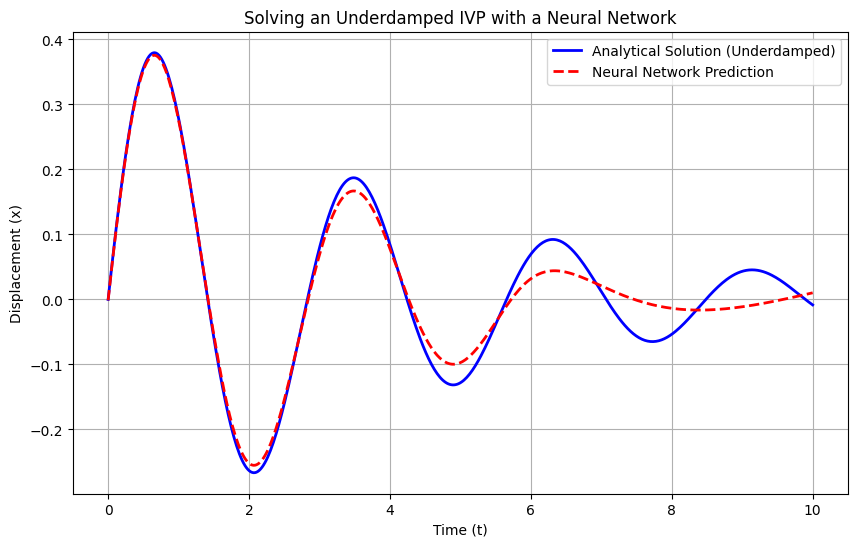

In [13]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Define the Physics and Network Parameters ---

# CHANGED: Parameters updated for an UNDERDAMPED system.
# The condition (mu/2)^2 < k must be met (assuming m=1).
# Here, (0.5/2)^2 = 0.0625, which is less than k=5.
mu = 0.5  # Damping coefficient
k = 5.0   # Spring constant

# Initial Conditions (remain the same)
t0 = 0.0
x0 = 0.0  # Initial position
v0 = 1.0  # Initial velocity

# Neural Network Architecture (remains the same)
num_hidden_layers = 2
num_neurons_per_layer = 32

# --- 2. Build the Neural Network (no changes needed) ---

model = keras.Sequential(name="Underdamped_Oscillator_Solver")
model.add(layers.InputLayer(shape=(1,)))
for i in range(num_hidden_layers):
    model.add(layers.Dense(num_neurons_per_layer, activation='tanh', name=f'hidden_{i+1}'))
model.add(layers.Dense(1, name='output_x'))

model.summary()


# --- 3. Create the Custom Training Step (no changes needed) ---
# The underlying differential equation has the same form, so the logic is identical.

t_initial_cond = tf.constant([[t0]], dtype=tf.float32)

@tf.function
def train_step(model, optimizer, t_domain):
    """
    Performs a single custom training step.
    """
    with tf.GradientTape() as tape:
        with tf.GradientTape() as outer_deriv_tape:
            outer_deriv_tape.watch(t_domain)
            with tf.GradientTape() as inner_deriv_tape:
                inner_deriv_tape.watch(t_domain)
                x = model(t_domain)
            dx_dt = inner_deriv_tape.gradient(x, t_domain)
        d2x_dt2 = outer_deriv_tape.gradient(dx_dt, t_domain)

        physics_residual = d2x_dt2 + mu * dx_dt + k * x
        loss_physics = tf.reduce_mean(tf.square(physics_residual))

        with tf.GradientTape() as initial_tape:
            initial_tape.watch(t_initial_cond)
            x_at_t0 = model(t_initial_cond)
        v_at_t0 = initial_tape.gradient(x_at_t0, t_initial_cond)

        loss_ic_pos = tf.square(x_at_t0 - x0)
        loss_ic_vel = tf.square(v_at_t0 - v0)
        loss_ic = tf.reduce_sum(loss_ic_pos + loss_ic_vel)

        total_loss = loss_physics + loss_ic

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return total_loss

# --- 4. Train the Network (no changes needed) ---

optimizer = keras.optimizers.Adam(learning_rate=0.001)
t_domain_train = tf.constant(np.linspace(0, 10, 500), dtype=tf.float32)[:, tf.newaxis]

epochs = 100000
for epoch in range(epochs):
    loss = train_step(model, optimizer, t_domain_train)
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.numpy():.6f}")


# --- 5. Evaluate the Results ---

# CHANGED: The analytical solution is now for an underdamped oscillator.
def analytical_solution(t, mu, k, v0, x0):
    """
    Provides the exact solution for an underdamped harmonic oscillator.
    """
    m = 1.0 # mass
    omega_n = np.sqrt(k / m) # Natural frequency
    zeta = mu / (2 * m * omega_n) # Damping ratio

    omega_d = omega_n * np.sqrt(1 - zeta**2) # Damped frequency

    # Coefficients from initial conditions
    A = x0
    B = (v0 + zeta * omega_n * x0) / omega_d

    # The solution
    x = np.exp(-zeta * omega_n * t) * (A * np.cos(omega_d * t) + B * np.sin(omega_d * t))
    return x

# Generate a test set of time points
t_test = np.linspace(0, 10, 500)
# Get the model's prediction
x_pred = model.predict(t_test).flatten()
# Get the true analytical solution
x_analytical = analytical_solution(t_test, mu, k, v0, x0)

# Calculate Mean Squared Error
mse = np.mean((x_pred - x_analytical)**2)
print(f"\nMean Squared Error vs Analytical Solution: {mse:.6f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_test, x_analytical, 'b-', linewidth=2, label='Analytical Solution (Underdamped)')
plt.plot(t_test, x_pred, 'r--', linewidth=2, label='Neural Network Prediction')
plt.title('Solving an Underdamped IVP with a Neural Network')
plt.xlabel('Time (t)')
plt.ylabel('Displacement (x)')
plt.legend()
plt.grid(True)
plt.show()